# On-the-fly ggame computation

In [48]:
import pandas as pd
import seaborn as sns
import numpy as np
import streamlit as st
import sklearn.metrics.pairwise as sklpw
from PIL import Image

In [138]:
# LOAD DATA
allgamedata_df = pd.read_pickle('datasources/BGG_FINAL.pkl') # USE ONLY FOR URLS
allgamedocvects = np.load('datasources/allgamedocvects.npz')['arr_0']
finalgamelist_df = pd.read_pickle('datasources/BGG_GameSimilarityKey.pkl')
finalgamelist_df.reset_index(drop=True,inplace=True) # So that row ids are indices to gamevector array

In [234]:
# FUNCTIONS
def getcompute_similar_games_by_name(mygameid,allgamedata_df,allgamedocvects,finalgamelist_df):
    myvectid = mygameid
    mygamevector = allgamedocvects[myvectid,:]
    mygamevector= mygamevector.reshape(-1,1)
    mysimilarities = []
    for t in range(0,allgamedocvects.shape[0]):
        currgamevect = allgamedocvects[t,:]
        currgamevect = currgamevect.reshape(-1,1)
        dum = sklpw.cosine_similarity(currgamevect.T,mygamevector.T)
        mysimilarities.append(dum[0][0])
    mycompletesimlist_df = pd.concat((finalgamelist_df['gamename'],pd.DataFrame({'Similarity':mysimilarities})),axis=1)
    mycompletesimlist_df.sort_values(by='Similarity',ascending=False,inplace=True)
    mytop10simlist_df = mycompletesimlist_df[1:11]
    # Create output list
    urllist=[]
    for gamename in mytop10simlist_df['gamename']:
        urllist.append(list(allgamedata_df.loc[allgamedata_df['game_name']==gamename,'bgg_url'])[0])
    mytop10simlist_df = pd.DataFrame({'Game':mytop10simlist_df['gamename'],'Similarity':mytop10simlist_df['Similarity'],'url':urllist})
    mytop10simlist_df.reset_index(drop=True,inplace=True)
    mytop10simlist_df.index = mytop10simlist_df.index+1
    return mytop10simlist_df


def get_similar_games_by_name_fuzzy(mygamename):
    gamename_matchlist = [fuzz.token_sort_ratio(x,mygamename) for x in finalgamelist_df['gamename']]
    possiblegame_idx  = [i for i, x in enumerate(gamename_matchlist) if x == max(gamename_matchlist)]
    possiblegame_idx = possiblegame_idx[0] # Get first, make it number
    possiblegame_name = list(finalgamelist_df.loc[finalgamelist_df['idx']==possiblegame_idx,'gamename'])[0]
    print('Best match: {}'.format(possiblegame_name))
    mygamevect = list(allgamesimilarities_df.loc[:,possiblegame_name])
    mygamevect_df = pd.DataFrame({'gamename':allgamesimilarities_df.index,'cosinesimilarity':mygamevect})
    mygamevect_df.sort_values(by='cosinesimilarity',inplace=True,ascending=False)
    return mygamevect_df

def make_clickable(url,text): # Make liks in pd df for url in table
    return f'<a target="_blank" href="{url}">{text}</a>'

def streamlitify_df(df):
    # Get original URLS
    df['Game_link'] = [make_clickable(a,b) for a,b in zip(list(df['url']),list(df['Game']))]
    return df


In [227]:
# CREATES THE DEMO GAME LIST
allgamedata_df['numeric_ranks']=[int(x) for x in allgamedata_df['game_rank']]
topranked_df = pd.DataFrame(allgamedata_df.loc[allgamedata_df['numeric_ranks']<=50,'game_name']) # To go back n forth
topranked_idx = topranked_df.index
demo_gamelist = tuple(list(finalgamelist_df.loc[topranked_idx,'gamename']))

## Pretend some game selected

In [211]:
mygamename = 'Gloomhaven'

In [237]:
mygameid = list(finalgamelist_df.index[finalgamelist_df['gamename']==mygamename])[0] # Need INDEX, not idx
mygameurl=list(allgamedata_df.loc[allgamedata_df['game_name']==mygamename,'bgg_url'])[0]
mytop10simlist_df = getcompute_similar_games_by_name(mygameid,allgamedata_df,allgamedocvects,finalgamelist_df)
mygamevect_df = streamlitify_df(mytop10simlist_df)

In [236]:

mygamevect_df

,Game,Similarity,url,Game_link
1,Forgotten Waters,0.988992,https://boardgamegeek.com//boardgame/302723/fo...,"<a target=""_blank"" href=""https://boardgamegeek..."
2,Fallen Land: A Post Apocalyptic Board Game,0.988874,https://boardgamegeek.com//boardgame/169141/fa...,"<a target=""_blank"" href=""https://boardgamegeek..."
3,Fallout,0.987675,https://boardgamegeek.com//boardgame/232918/fa...,"<a target=""_blank"" href=""https://boardgamegeek..."
4,The World of SMOG: Rise of Moloch,0.985400,https://boardgamegeek.com//boardgame/209324/wo...,"<a target=""_blank"" href=""https://boardgamegeek..."
5,Paradox,0.984702,https://boardgamegeek.com//boardgame/161297/pa...,"<a target=""_blank"" href=""https://boardgamegeek..."
6,Machina Arcana,0.984538,https://boardgamegeek.com//boardgame/144743/ma...,"<a target=""_blank"" href=""https://boardgamegeek..."
7,London Dread,0.984230,https://boardgamegeek.com//boardgame/178134/lo...,"<a target=""_blank"" href=""https://boardgamegeek..."
8,Oathsworn: Into the Deepwood,0.983738,https://boardgamegeek.com//boardgame/251661/oa...,"<a target=""_blank"" href=""https://boardgamegeek..."
9,The Hills Rise Wild!,0.983729,https://boardgamegeek.com//boardgame/799/hills...,"<a target=""_blank"" href=""https://boardgamegeek..."
10,Overturn: Rising,0.983659,https://boardgamegeek.com//boardgame/240624/ov...,"<a target=""_blank"" href=""https://boardgamegeek..."


#  ******** ROUGH STUFF ****************

In [129]:
finalgamelist_df.head(2)

,idx,gamename
0,0,Gloomhaven
1,1,Pandemic Legacy: Season 1


(18561, 2)

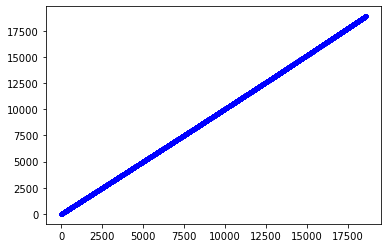

In [137]:
plt.plot(finalgamelist_df.index,finalgamelist_df['idx'],'b.')